In [29]:
 pqf = "/User/nfs/clone/netops_features_parquet/20200315T165323-20200316T011133.parquet"

In [37]:
import pandas as pd
df = pd.read_parquet(pqf)
df.head(1)

,,,,cpu_utilization,cpu_utilization_is_error_raw,latency,latency_is_error_raw,packet_loss,packet_loss_is_error_raw,throughput,throughput_is_error_raw,is_error_raw,cpu_utilization_minutely,...,is_error_minute,cpu_utilization_hourly,cpu_utilization_is_error,latency_hourly,latency_is_error,packet_loss_hourly,packet_loss_is_error,throughput_hourly,throughput_is_error,is_error
timestamp,company,data_center,device,,,,,,,,,,,,,,,,,,,,,
2020-03-15 16:53:23.835,Murray_Inc,Sara_Tunnel,2092606280664,63.24,False,0.00,False,2.87,False,233.57,False,False,62.49,...,0.00,74.31,False,16.26,False,8.19,False,216.93,False,1.00


In [30]:
# Copyright 2018 Iguazio
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact, TableArtifact
from mlrun import get_or_create_ctx
from yellowbrick.target import ClassBalance
from sklearn.preprocessing import StandardScaler

from typing import IO, AnyStr, Union, List, Optional

In [31]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [42]:
def _gcf_clear(plt):
    plt.cla()
    plt.clf()
    plt.close() 

def describe(
    context: MLClientCtx,
    table: Union[DataItem, str],
    label_column: str,
    class_labels: List[str],
    key: str = "table-summary",
) -> None:
    """Summarize a table

    TODO: merge with dask version

    :param context:         the function context
    :param table:           pandas dataframe
    :param key:             key of table summary in artifact store
    """
    _gcf_clear(plt)
    
    base_path = "/tmp/test"
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(base_path+"/plots", exist_ok=True)
    
    print(f'TABLE {table}')
    table = pd.read_parquet(str(table))
    header = table.columns.values
    
    # describe table
    sumtbl = table.describe()
    sumtbl = sumtbl.append(len(table.index)-table.count(), ignore_index=True)
    sumtbl.insert(0, "metric", ["count", "mean", "std", "min","25%", "50%", "75%", "max", "nans"])
    
    sumtbl.to_csv(os.path.join(base_path, key+".csv"), index=False)
    context.log_artifact(key, local_path=key+".csv")

    # plot class balance, record relative class weight
    _gcf_clear(plt)
    
    labels = table.pop(label_column)
    class_balance_model = ClassBalance(labels=class_labels)
    class_balance_model.fit(labels)
    
    scale_pos_weight = class_balance_model.support_[0]/class_balance_model.support_[1]
    #context.log_artifact("scale_pos_weight", f"{scale_pos_weight:0.2f}")
    context.log_artifact("scale_pos_weight", str(scale_pos_weight))

    class_balance_model.show(outpath=os.path.join(base_path, "plots/imbalance.png"))
    context.log_artifact(PlotArtifact("imbalance", body=plt.gcf()), local_path="plots/imbalance.html")
    
    # plot feature correlation
    _gcf_clear(plt)
    tblcorr = table.corr()
    ax = plt.axes()
    sns.heatmap(tblcorr, ax=ax, annot=False, cmap=plt.cm.Reds)
    ax.set_title("features correlation")
    plt.savefig(os.path.join(base_path, "plots/corr.png"))
    context.log_artifact(PlotArtifact("correlation",  body=plt.gcf()), local_path="plots/corr.html")
    
    # plot histogram
    
    _gcf_clear(plt)
    ax = plt.axes()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    figarray = table.hist(ax=ax, ylabelsize=5, xlabelsize=5)
    for row in figarray:
        for f in row:
            f.set_title("")
    ax.set_title("features histogram")
    plt.savefig(os.path.join(base_path, "plots/hist.png"))
    context.log_artifact(PlotArtifact("histograms",  body=plt.gcf()), local_path="plots/hist.html")
       
    _gcf_clear(plt)

In [43]:
mlrunctx = get_or_create_ctx('describe')

[mlrun] 2020-03-15 18:17:13,177 logging run results to: http://10.196.67.76:8080


In [44]:
mlrunctx.artifact_path

''

TABLE /User/nfs/clone/netops_features_parquet/20200315T165323-20200316T011133.parquet
[mlrun] 2020-03-15 18:17:14,223 log artifact summary at summary.csv, size: None, db: Y
[mlrun] 2020-03-15 18:17:14,321 log artifact scale_pos_weight at scale_pos_weight, size: 19, db: Y
[mlrun] 2020-03-15 18:17:14,468 log artifact imbalance at plots/imbalance.html, size: 17404, db: Y
[mlrun] 2020-03-15 18:17:15,193 log artifact correlation at plots/corr.html, size: 53794, db: Y


/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

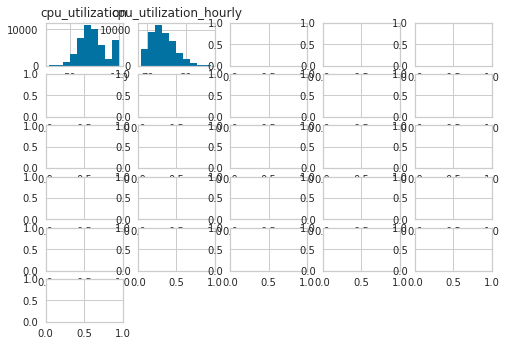

In [45]:
key = "summary"
label_column = "is_error"
class_labels = [0, 1]

describe(mlrunctx,pqf,label_column,class_labels,key)